In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [ ]:
def make_fake_data() -> pd.DataFrame:
    """_Make some fake data for testing purposes.

    Returns:
        df (pd.DataFrame): DataFrame with time as index
    """

    t = np.linspace(0, 3, 200)**2
    y1 = np.sin(t)
    y2 = np.cos(1.3*t)
    y3 = np.heaviside(t-1, 0) - .5
    y = np.vstack((y1, y2, y3)).T
    y[175:, :] = np.array([[-.1, 0, .1]])
    df = pd.DataFrame(y, columns = ['signal1', 'signal2', 'signal3'], index= t)
    df.index.name = 't'
    print(df)
    return df


def normalize_data(df :  pd.DataFrame) -> pd.DataFrame:
    """Normalizes the data to range [0, 1] for each signal.
    Args:
        df (pd.DataFrame): DataFrame with time as index and signals as columns.
    Returns:
        df (pd.DataFrame): Normalized DataFrame with time as index and signals as columns.
    """

    df = (df - df.min())/(df.max() - df.min())    
    return df


def get_distances(df) -> np.ndarray:
    
    """Calculates the linear interpolation error assuming fit based on first and last points.

    Args:
        df (pd.DataFrame): DataFrame with time as index and signals as columns.

    Returns:
        error (np.ndarray): The linear interpolation error for each intermediate point with shape (N_timepoints, N_signals).
    """

    t1 = df.index[0].reshape(-1, 1)
    t2 = df.index[-1].reshape(-1, 1)      
    tn = df.index.values.reshape(-1, 1) 
    values = df.values

    m = (values[-1,:] -values[0,:])/(t2 - t1)
    y_fit = m * (tn - t1) + values[0,:]
    error = y_fit - values
    return error



def get_crit_points(df : pd.DataFrame, tolerance : float = 0.01, normalize : bool = True, include_global_extrema : bool = True) -> np.ndarray:
    """Finds the critical points in the data using a linear interpolation error tolerance.      
    Args:
        df (pd.DataFrame): DataFrame with time as index and signals as columns.
        tolerance (float, optional): The maximum allowable linear interpolation error. Defaults to 0.01 (1%).
        normalize (bool, optional): Whether to normalize the data to range [0, 1] for each signal. Defaults to True.
        include_global_extrema (bool, optional): Whether to include global extrema as critical points. Defaults to True.    
    Returns:
        I_crit (np.ndarray): Boolean array indicating critical points with shape (N_timepoints,).           

    """

    if normalize == True:
        df = normalize_data(df)

    N_timepoints = len(df)
    N_signals = len(df.columns)
    I_crit = np.zeros(N_timepoints, dtype=bool)

    I_crit[0] = True
    I_crit[-1] = True

    if include_global_extrema:
        I_min = df.values.argmin(axis = 0)
        I_max = df.values.argmax(axis = 0)
        I_crit[I_min] = True
        I_crit[I_max] = True


    I_last_point = 0

    for i in range(1, N_timepoints):
        
        if I_crit[i-1] == True:
            I_last_point = i-1
        else:
            I_slice = df.index[I_last_point:i+1]
            df_cur = df.loc[I_slice,:]
            error = get_distances(df_cur)

            if np.any(np.abs(error) >tolerance):
                I_last_point = i-1
                I_crit[I_last_point] = True

    return I_crit


def calculate_linear_interp_error(df : pd.DataFrame, I_crit : np.ndarray) -> pd.DataFrame:
    """Calculates the linear interpolation error assuming fit based on critical points.
    Args:
        df (pd.DataFrame): DataFrame with time as index and signals as columns.
        I_crit (np.ndarray): Boolean array indicating critical points with shape (N_timepoints,).   
    Returns:
        df_error (pd.DataFrame): DataFrame with time as index and signals as columns containing the linear interpolation error.
    """

    df_reduced = df*np.nan
    df_reduced.loc[df.index[I_crit]] = df.loc[df.index[I_crit]]
    df_reduced = df_reduced.interpolate(method = 'index')
    df_error = df_reduced-df

    return df_error

def make_plots(df : pd.DataFrame, df_optimized : pd.DataFrame, df_error : pd.DataFrame, tolerance : float):
    """Creates plots to visualize the original data, optimized data, and error.
    """
    fig, ax = plt.subplots(2, 1)    
    ax[0].plot(df, marker = 'x',label = df.columns)
    ax[0].plot(df_optimized, marker = 'o', color = 'k')
    ax[0].set_title(f'reduced {len(df)} points to {len(df_optimized)} points using tolerance = {tolerance} ({tolerance*100:.1f}%)')
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('y')
    ax[1].plot( df_error, label = df.columns)
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('absolute error')
    ax[0].legend()
    ax[1].legend()



           signal1   signal2  signal3
t                                    
0.000000  0.000000  1.000000     -0.5
0.000227  0.000227  1.000000     -0.5
0.000909  0.000909  0.999999     -0.5
0.002045  0.002045  0.999996     -0.5
0.003636  0.003636  0.999989     -0.5
...            ...       ...      ...
8.641827 -0.100000  0.000000      0.1
8.730689 -0.100000  0.000000      0.1
8.820005 -0.100000  0.000000      0.1
8.909775 -0.100000  0.000000      0.1
9.000000 -0.100000  0.000000      0.1

[200 rows x 3 columns]


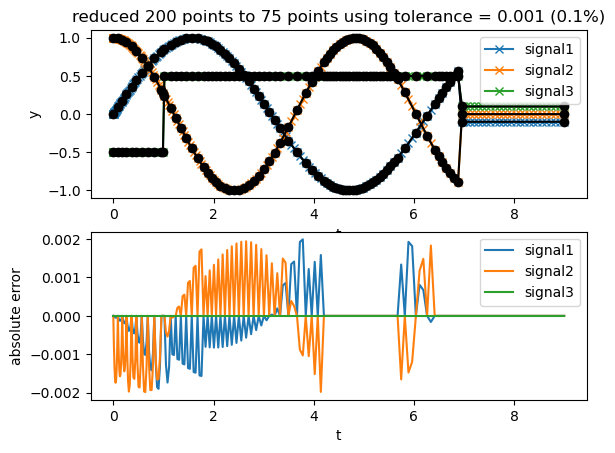

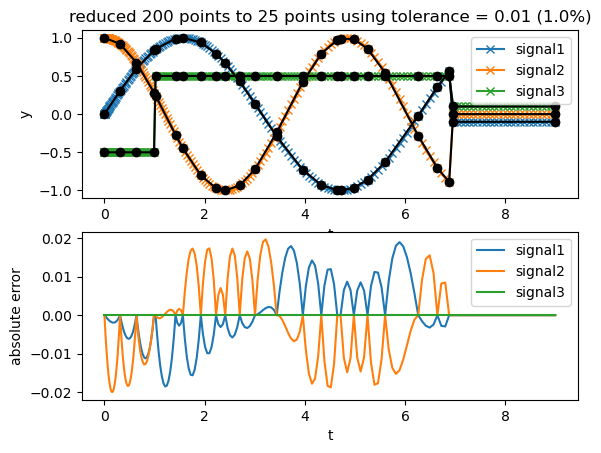

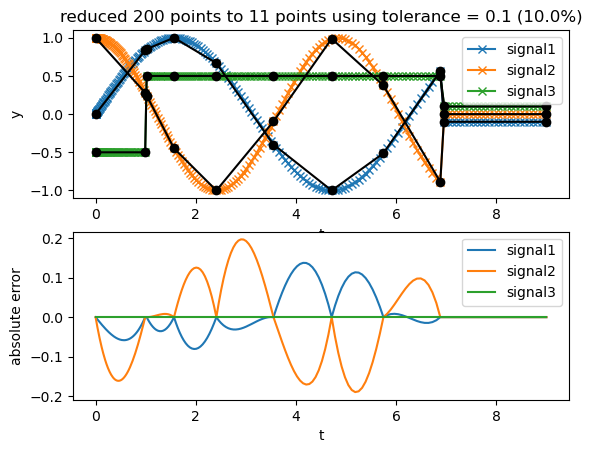

In [171]:
df = make_fake_data()

for tolerance in [0.001, 0.01, 0.1]:
    I_crit = get_crit_points(df, tolerance = tolerance)
    df_optimized = df.loc[df.index[I_crit],:]
    df_error = calculate_linear_interp_error(df, I_crit)
    make_plots(df, df_optimized, df_error, tolerance)

In [170]:
df

,signal1,signal2,signal3
t,,,
0.000000,0.000000,1.000000,-0.5
0.000227,0.000227,1.000000,-0.5
0.000909,0.000909,0.999999,-0.5
0.002045,0.002045,0.999996,-0.5
0.003636,0.003636,0.999989,-0.5
...,...,...,...
8.641827,-0.100000,0.000000,0.1
8.730689,-0.100000,0.000000,0.1
8.820005,-0.100000,0.000000,0.1
